
--- Labeling 80 images ---



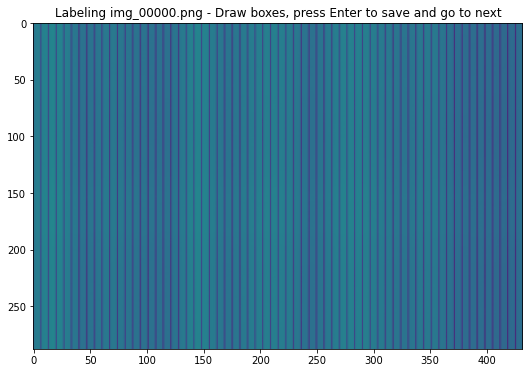

In [1]:
# YOLO Labeling Tool in Jupyter Notebook (Manual Save Before Next)

import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image
from IPython.display import clear_output

# === CONFIG ===
image_dir = '/datax/scratch/jliang/hand_label_masking_dataset/waterfall/train'   # folder of PNGs
label_dir = '/datax/scratch/jliang/hand_label_masking_dataset/train/labels'   # where .txt files go
os.makedirs(label_dir, exist_ok=True)

image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
start_index = 0  # change if resuming later

# === Globals ===
current_boxes = []
start_point = None
current_rect = None
current_image = None
ax = None
fig = None
width, height = None, None
image_name = None
image_idx = start_index


def normalize_box(x0, y0, x1, y1, w, h):
    xc = (x0 + x1) / 2 / w
    yc = (y0 + y1) / 2 / h
    bw = abs(x1 - x0) / w
    bh = abs(y1 - y0) / h
    return (0, xc, yc, bw, bh)  # class_id = 0


def save_labels(path, boxes):
    with open(path, 'w') as f:
        for box in boxes:
            f.write(f"{box[0]} {box[1]:.6f} {box[2]:.6f} {box[3]:.6f} {box[4]:.6f}\n")


def draw_image():
    global fig, ax, start_point, current_rect, current_boxes, current_image, width, height, image_name, image_idx

    if image_idx >= len(image_files):
        print("All images labeled!")
        return

    current_boxes = []
    start_point = None
    current_rect = None
    image_name = image_files[image_idx]
    image_path = os.path.join(image_dir, image_name)
    current_image = Image.open(image_path)
    width, height = current_image.size

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(current_image)
    ax.set_title(f"Labeling {image_name} - Draw boxes, press Enter to save and go to next")
    fig.canvas.mpl_connect('button_press_event', on_press)
    fig.canvas.mpl_connect('motion_notify_event', on_motion)
    fig.canvas.mpl_connect('button_release_event', on_release)
    fig.canvas.mpl_connect('key_press_event', on_key)
    plt.show()


def on_press(event):
    global start_point, current_rect
    if event.inaxes != ax: return
    start_point = (event.xdata, event.ydata)
    current_rect = Rectangle(start_point, 0, 0, edgecolor='red', facecolor='none', linewidth=2)
    ax.add_patch(current_rect)


def on_motion(event):
    if current_rect is None or start_point is None or event.inaxes != ax:
        return
    x0, y0 = start_point
    dx = event.xdata - x0
    dy = event.ydata - y0
    current_rect.set_width(dx)
    current_rect.set_height(dy)
    fig.canvas.draw_idle()


def on_release(event):
    global current_boxes, current_rect, start_point
    if current_rect is None or start_point is None or event.inaxes != ax:
        return
    x0, y0 = start_point
    x1, y1 = event.xdata, event.ydata
    norm_box = normalize_box(x0, y0, x1, y1, width, height)
    current_boxes.append(norm_box)
    print(f"Added box: {norm_box}")
    start_point = None
    current_rect = None


def on_key(event):
    global image_idx
    if event.key == 'enter':
        save_path = os.path.join(label_dir, image_name.replace('.png', '.txt'))
        save_labels(save_path, current_boxes)
        print(f"Saved {len(current_boxes)} boxes to {save_path}")
        plt.close()
        image_idx += 1
        clear_output(wait=True)
        draw_image()

# Start labeling
print(f"\n--- Labeling {len(image_files)} images ---\n")
draw_image()
